In [1]:
"""
Activity

(Wednesday)
Linear Regression

    X-y split (y is the target variable, which is the total claim amount) [X]
    Train-test split.                                                     [X]
    Standardize the data (after the data split).                          [X]
    Apply linear regression.                                              [ ]
    Model Interpretation.                                                 [ ]

(Thursday)
Model Validation

    Model Evaluation:
        MSE.                                                              [ ]
        RMSE.                                                             [ ]
        MAE.                                                              [ ]
        R2.                                                               [ ]
        Adjusted R2.                                                      [ ]
    Feature Importance.

Model Iteration (Thursday and Friday)

    Please rerun the model after adding the hot encoded categorical variables as well as 
    other numeric categroical variables (e.g. number of open complaintes).
    
    (Optional) Please rerun the model after removing the outliers and compare the results using R2 metric.

"""

'\nActivity\n\n(Wednesday)\nLinear Regression\n\n    X-y split (y is the target variable, which is the total claim amount) [X]\n    Train-test split.                                                     [X]\n    Standardize the data (after the data split).                          [X]\n    Apply linear regression.                                              [ ]\n    Model Interpretation.                                                 [ ]\n\n(Thursday)\nModel Validation\n\n    Model Evaluation:\n        MSE.                                                              [ ]\n        RMSE.                                                             [ ]\n        MAE.                                                              [ ]\n        R2.                                                               [ ]\n        Adjusted R2.                                                      [ ]\n    Feature Importance.\n\nModel Iteration (Thursday and Friday)\n\n    Please rerun the model after add

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Objectives

**Linear Regression**
- X-y split (y is the target variable, which is the total claim amount) [X]
- Train-test split.                                                     [X]
- Standardize the data (after the data split).                          [X]
- Apply linear regression.                                              [X]
- Model Interpretation.                                                 [O]
-------------------------------------------------------------------------------
**Model Evaluation:**
- MSE                                                              [X]
- RMSE                                                             [X]
- MAE                                                              [X]
- R2                                                               [X]
- Adjusted R2                                                      [X]

## Drilled down TO DOs

- **extract / load data** ✅
-------------------------
- **preprocessing / transforming**
    - split numerical and categorical data ✅
    - numerical data preprocessing .🔄
        - drop "number_of_open_complaints", because it's technically categorical data ✅
        - get rid of outliers if there are any 🔄
    - categorical data preprocessing ✅
        - drop "effective_to_date", because it's useless in our case ✅
        - insert "number_of_open_complaints", because it's technically categorical data ✅
        - separate ordinal and nominal data ✅
            - ordinal data ✅
                - scale: policy (personal < business < special [l1 < l2 < l3] ✅
                - scale: education (HS or lower < BA < MA = College < Doctor) ✅
                - scale: coverage (basic < extended < premium) ✅
    - split categorical into nominal and ordinal ✅
    - check for multicollinearity and drop highly correlated features ✅
-------------------------      
- **linear regression modeling**
    - numerical (with / without outliers) only ✅
    - numerical + categorial (total) ✅
    - numerical + categorical (ordinal only) ✅
    - numerical + categorical (nominal only) ✅
    - categorial total only ✅
    - categorical ordinal only ✅
    - categorical nominal only ✅


## Data Preprocessing & Transformation

### Extract / load data

In [3]:
def load_original_data():
    df = pd.read_csv(r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\IH_RH_DA_FT_AUG_2022\Class_Materials\Case_Studies\Customer_Analysis_Case_Study\Data\Data_Marketing_Customer_Analysis_Round3.csv")        
    return df

df = load_original_data()

### Preprocessing / transforming data

#### Split numerical and categorical data

In [4]:
def get_numerical(df):
    df_numerical = df.select_dtypes(exclude=['object'])
    # Drop number of open complaints as this is technically categorical data
    return df_numerical

def get_categorical(df):
    df_categorical = df.select_dtypes(include=['object'])
    return df_categorical

df_numerical = get_numerical(df)

#### Numerical data processing

In [7]:
# Drop "number_of_open_complaints", because it's technically categorical data
df_numerical.drop("number_of_open_complaints", axis=1, inplace=True)

"""
- not checking for outliers in customer_lifetime_value, because also extreme cases are reasonable
"""
df_num_cols_selected = ['income', 'monthly_premium_auto', 'months_since_last_claim', 
                        'months_since_policy_inception', 'number_of_policies']

# Get rid of outliers if there are any
def remove_outliers(df,columns,n_std):
    """
    function for removing outliers from given df;
    select in which column outliers are to be removed;
    specify "outlier condition" by supplying number of standard deviations;
    """
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*std))]
        #df.reset_index(drop=True, inplace=True)
        
    return df

df_numerical_nofliers = remove_outliers(df_numerical, df_num_cols_selected, 3)

#### Categorical data processing

In [8]:
def transform_categorical(df):
    df_categorical = get_categorical(df)
    # Drop effective to date column
    df_categorical.drop("effective_to_date", axis=1, inplace=True) 
    
    df = load_original_data()
    # Insert number of open complaints as this is technically categorical data
    df_categorical.insert(len(df_categorical.columns)-1, "number_of_open_complaints", df["number_of_open_complaints"])
    
    # Convert policy to numbers for ordinal
    policy_dict = {"personal l1": 1, "personal l2": 2, "personal l3": 3,
                    'corporate l1': 4, 'corporate l2': 5, 'corporate l3': 6,
                    'special l1': 7, 'special l2': 8, 'special l3': 9}
    #policies = [policy_dict[policy] for policy in df_categorical["policy"]]
    ## Group policies
    policies = ["personal" if pol in ("personal l1", "personal l2", "personal l3")
               else "corporate" if pol in ("corporate l1", "corporate l2", "corporate l3")
               else "special" for pol in df_categorical["policy"]]
    df_categorical["policy"] = policies
    
    # Convert education  to numbers for ordinal
    education_dict = {'high school or below': 0,
                      'bachelor': 1,
                      'master': 2,
                      'college': 2,
                      'doctor': 3}
    educations = [education_dict[edu] for edu in df_categorical["education"]]
    df_categorical["education"] = educations
    
    # Convert coverage to numbers for ordinal
    df_categorical["coverage"] = [1 if x == "basic"
                                 else 2 if x == "extended"
                                 else 3
                                 for x in df_categorical["coverage"]]
    
    # Convert months to numbers for ordinal
    #months_dict = {"jan": 0,
              #"feb": 1}
    #df_categorical["month"] = [months_dict[mon] for mon in df_categorical["month"]]
    
    # Group luxury cars together
    df_categorical["vehicle_class"] = ["luxury" if car in ("luxury car", "luxury suv")
                                      else car
                                      for car in df_categorical["vehicle_class"]]
    
    return df_categorical

df_categorical = transform_categorical(df)

#### Split categorical into nominal and ordinal

In [9]:
df_categorical_ordinal = df_categorical[["education", "policy", "number_of_open_complaints", "coverage"]]
df_categorical_nominal = df_categorical.drop(columns=["education", "policy", "number_of_open_complaints", "coverage"])

### Check for multicollinearity and drop highly correlated features

#### Create `correlation heatmap` to show interaction of every feature with every other feature

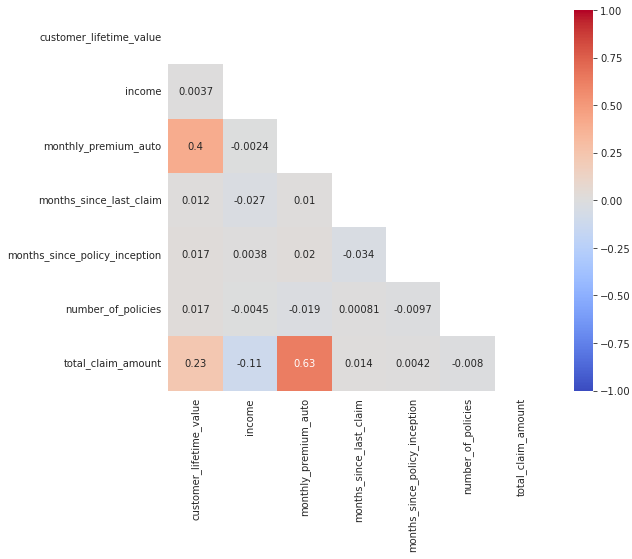

In [10]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

- highest correlation (0.63) between **`total_claim_amount`** and **`montly_premium_auto`**
- second highest correlation (0.40) between **`customer_lifetime_value`** and **`montly_premium_auto`**

#### Check if there are highly correlated features and drop them if there are any

In [11]:
def show_corr_higher_threshold(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    return [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

show_corr_higher_threshold(df_numerical, 0.8)

[]

`There are no highly correlated (> 0.8) features, so none will be dropped!`

### One Hot/Label Encoding of the categorical variables

In [12]:
df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True) # 43 columns
# df_categorical_hotcoded_ = pd.get_dummies(df_categorical, drop_first=False) # 58 columns

df_categorical_ordinal_hotcoded = pd.get_dummies(df_categorical_ordinal, drop_first=True)
df_categorical_nominal_hotcoded = pd.get_dummies(df_categorical_nominal, drop_first=True)

df_categorical_combined = pd.concat((df_categorical_ordinal_hotcoded,df_categorical_nominal_hotcoded), axis=1)

## Linear Regression Modeling

In [13]:
test_size = 0.3

### Numerical (with outliers) ONLY

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [14]:
X = df_numerical.drop('total_claim_amount', axis=1)
y = df_numerical["total_claim_amount"]

#### Train - Test - Split

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [16]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 6) (3207, 6)
Coefficients:  [-10.48705083 -31.64075533 192.06479188   0.90000195  -1.93392374
  -0.50801395]


Evaluating Model Performance

In [17]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

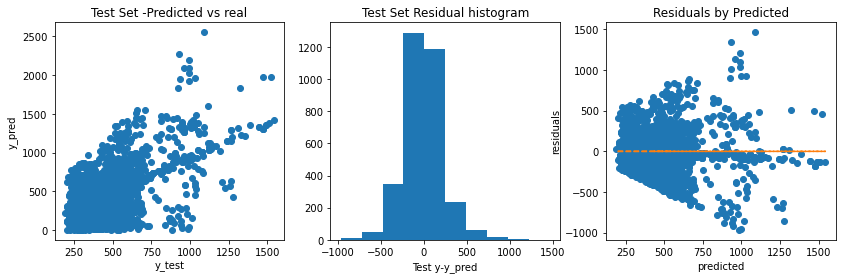

In [18]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

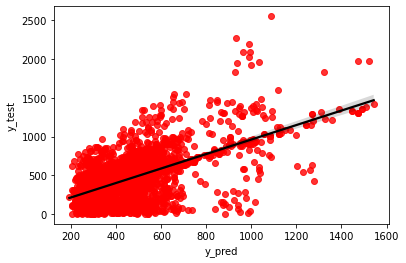

In [19]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [20]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 50842.55
MAE: 153.03
-----
R^2 for <numerical (with outliers) only> is 0.39.
Adjusted R^2 for <numerical (with outliers) only> is 0.39.


Getting number of parameters

In [21]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,monthly_premium_auto,192.064792
1,income,31.640755
0,customer_lifetime_value,10.487051
4,months_since_policy_inception,1.933924
3,months_since_last_claim,0.900002
5,number_of_policies,0.508014


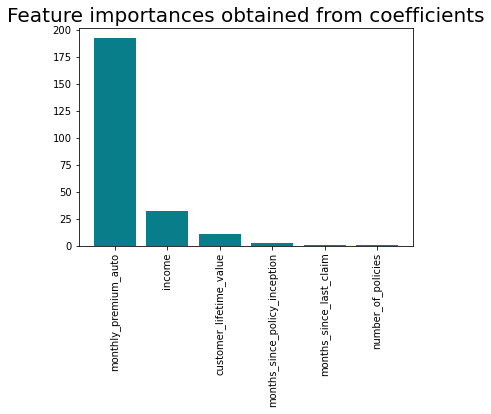

In [22]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [23]:
df_categorical

,region,response,coverage,education,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,number_of_open_complaints,vehicle_size
0,central,no,1,2,feb,employed,m,suburban,married,corporate auto,corporate,offer3,agent,four-door car,0,medsize
1,west region,no,1,2,jan,unemployed,f,suburban,single,personal auto,personal,offer4,call center,four-door car,0,medsize
2,east,no,1,1,feb,employed,m,suburban,single,personal auto,personal,offer3,call center,suv,0,medsize
3,north west,yes,2,2,jan,employed,m,suburban,single,corporate auto,corporate,offer2,branch,four-door car,0,medsize
4,north west,no,3,1,jan,medical leave,f,suburban,married,personal auto,personal,offer1,branch,four-door car,0,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,3,1,jan,unemployed,f,suburban,married,personal auto,personal,offer3,web,luxury,0,medsize
10685,north west,no,1,2,jan,employed,f,urban,married,personal auto,personal,offer2,branch,four-door car,0,medsize
10686,central,no,2,1,feb,employed,f,rural,married,corporate auto,corporate,offer1,web,luxury,0,medsize
10687,west region,no,3,2,feb,employed,f,urban,divorced,personal auto,personal,offer1,branch,suv,4,medsize


### Numerical (with outliers) + Categorial (total)

In [25]:
df_numerical_categorical = pd.concat((df_categorical_hotcoded, df_numerical), axis=1)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [26]:
X = df_numerical_categorical.drop('total_claim_amount', axis=1)
y = df_numerical_categorical["total_claim_amount"]

#### Train - Test - Split

In [27]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [28]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 39) (3207, 39)
Coefficients:  [-4.76070850e+00 -8.54372410e+00  9.17908724e-03  2.36714218e+00
 -1.17283834e+00  1.25875982e-01 -7.73527158e+00 -4.92304298e-01
 -6.77950368e+00  2.53924865e+00 -2.30349634e+00  3.25414023e+01
  8.69660870e+00  1.83049367e+02  8.30841847e+01 -2.46868134e+00
  2.82534307e+01 -6.48177312e+12 -1.87160967e+12  6.48177312e+12
  1.87160967e+12  7.58871339e+00  4.17004703e+00  3.01505855e+00
 -3.40305165e-01 -4.37082025e-01  1.70185799e+00  3.66477628e+00
 -3.55943671e+00 -6.44344130e+00 -4.49058763e-01 -2.91779708e+00
 -3.98808272e-01 -3.09819172e+00 -3.71812500e+00  1.80575296e+02
  3.00048825e+00 -5.15503975e-01  1.10792090e+00]


Evaluating Model Performance

In [29]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

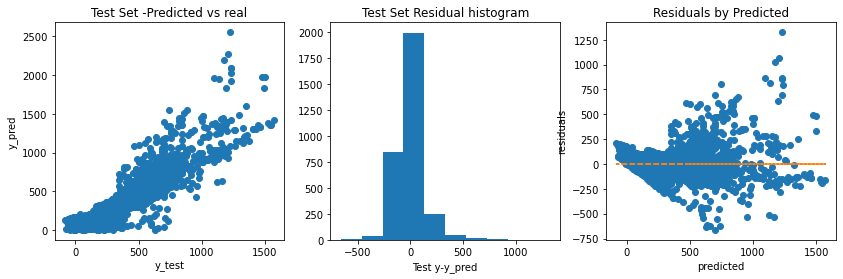

In [30]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

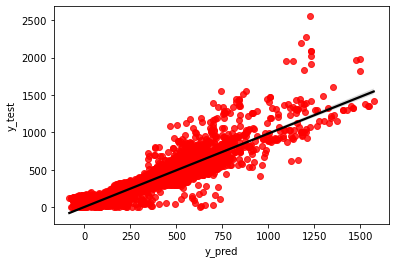

In [31]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [32]:
mse_2 = round(mse(y_test,y_pred),2)
rmse_2 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_2 = round(mae(y_test,y_pred),2)

print("MSE:", mse_2) # shows squared error (harder to interpret)
print("MAE:", mae_2) # shows real error (in $)
print("-----")

# R^2
R2_2 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_2 = round(1 - (1-R2_2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_2,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_2,2)}.")

MSE: 19427.29
MAE: 95.6
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.77.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.77.


Getting number of parameters

In [33]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,policy_personal,6.481773e+12
1,policy_type_personal auto,6.481773e+12
2,policy_special,1.871610e+12
3,policy_type_special auto,1.871610e+12
4,location_code_suburban,1.830494e+02
5,monthly_premium_auto,1.805753e+02
6,location_code_urban,8.308418e+01
7,employment_status_unemployed,3.254140e+01
8,marital_status_single,2.825343e+01
9,gender_m,8.696609e+00


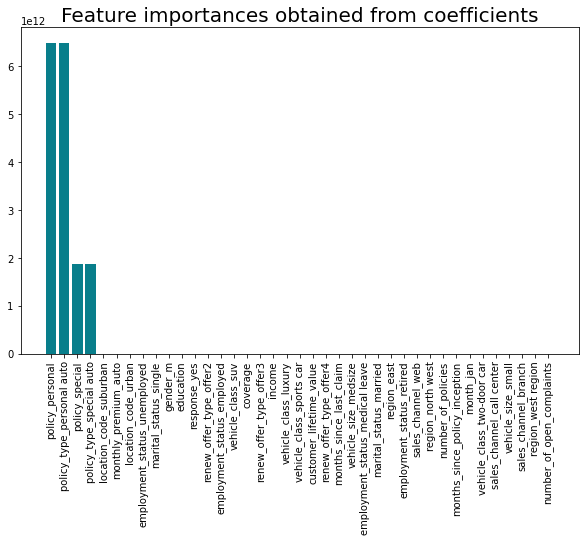

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Numerical (without outliers) + Categorial (total)

In [35]:
df_numerical_categorical = pd.merge(df_categorical_hotcoded, df_numerical_nofliers, left_index=True, right_index=True)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [36]:
X = df_numerical_categorical.drop('total_claim_amount', axis=1)
y = df_numerical_categorical["total_claim_amount"]

#### Train - Test - Split

In [37]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=123)

#### Standardize the data after data split

In [38]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7320, 39) (3138, 39)
Coefficients:  [-4.33593528e+00 -7.45091736e+00 -1.93294648e+00  1.24585669e+00
 -8.11730509e-01  2.88773189e+00 -7.31261061e+00 -1.28564110e+00
 -3.05014583e+00  2.46639316e+00 -9.46803893e-01  3.45265952e+01
  7.55109124e+00  1.83361169e+02  8.52784470e+01 -3.93328498e+00
  2.45774218e+01  1.55179346e+13 -6.79262488e+13 -1.55179346e+13
  6.79262488e+13  5.50269475e+00  1.28523952e+00  1.11625875e+00
  1.08400005e+00  1.12249951e+00  3.21105434e+00  5.91161799e+00
 -1.75047203e+00 -5.08512598e+00 -3.55599559e-01 -2.35458542e+00
  2.00538081e+00 -2.06198032e+00 -4.89975562e+00  1.38050003e+02
  2.45215485e+00 -8.29284361e-01  1.05032125e+00]


Evaluating Model Performance

In [39]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

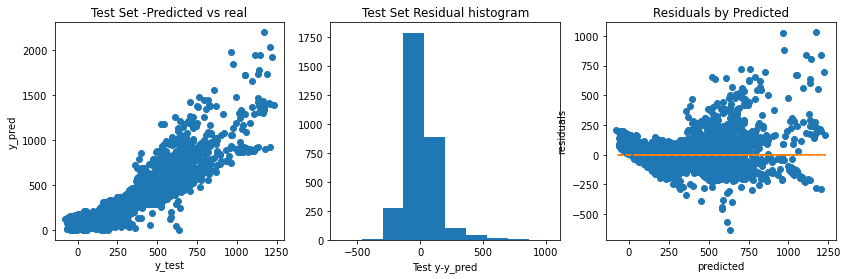

In [40]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

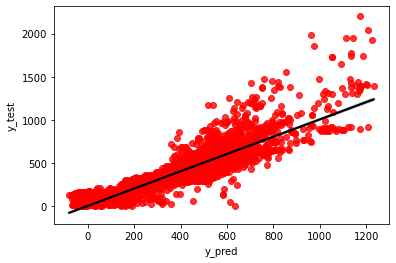

In [41]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [42]:
mse_2a = round(mse(y_test,y_pred),2)
rmse_2a = round(np.sqrt(mse(y_test,y_pred)),2)
mae_2a = round(mae(y_test,y_pred),2)

print("MSE:", mse_2a) # shows squared error (harder to interpret)
print("MAE:", mae_2a) # shows real error (in $)
print("-----")

# R^2
R2_2a = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_2a = round(1 - (1-R2_2a)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_2a,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_2a,2)}.")

MSE: 17605.56
MAE: 92.24
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.76.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.76.


Getting number of parameters

In [43]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,policy_special,6.792625e+13
1,policy_type_special auto,6.792625e+13
2,policy_type_personal auto,1.551793e+13
3,policy_personal,1.551793e+13
4,location_code_suburban,1.833612e+02
5,monthly_premium_auto,1.380500e+02
6,location_code_urban,8.527845e+01
7,employment_status_unemployed,3.452660e+01
8,marital_status_single,2.457742e+01
9,gender_m,7.551091e+00


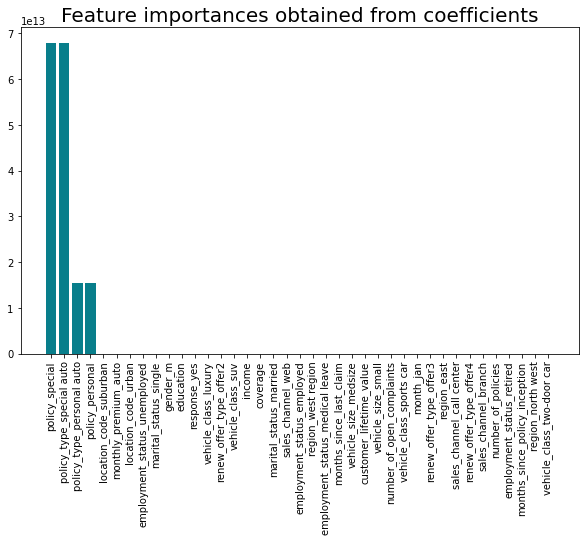

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Numerical (with outliers) + Categorial (ordinal)

In [45]:
df_numerical_categorical_ordinal = pd.concat((df_categorical_ordinal_hotcoded, df_numerical), axis=1)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [46]:
X = df_numerical_categorical_ordinal.drop('total_claim_amount', axis=1)
y = df_numerical_categorical_ordinal["total_claim_amount"]

#### Train - Test - Split

In [47]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [48]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 11) (3207, 11)
Coefficients:  [-32.48441656   0.33342258  -5.68107346   4.82147219   5.02987609
 -11.77784359 -32.06569518 193.87645562   1.38772337  -1.88037228
  -0.68733961]


Evaluating Model Performance

In [49]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

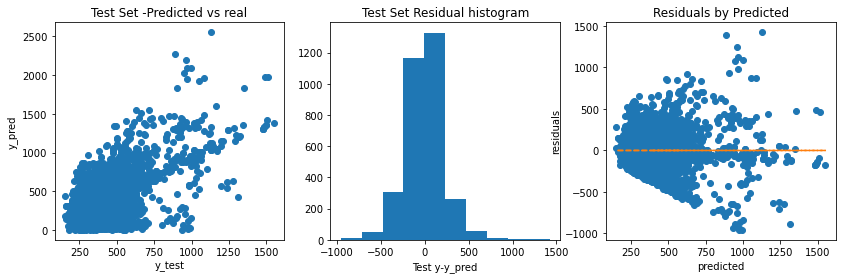

In [50]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

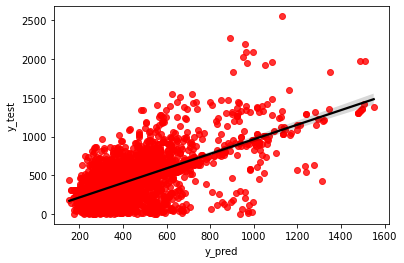

In [51]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [52]:
mse_3 = round(mse(y_test,y_pred),2)
rmse_3 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_3 = round(mae(y_test,y_pred),2)

print("MSE:", mse_3) # shows squared error (harder to interpret)
print("MAE:", mae_3) # shows real error (in $)
print("-----")

# R^2
R2_3 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_3 = round(1 - (1-R2_3)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_3,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_3,2)}.")

MSE: 49836.92
MAE: 153.58
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.4.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.4.


Getting number of parameters

In [53]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,monthly_premium_auto,193.876456
1,education,32.484417
2,income,32.065695
3,customer_lifetime_value,11.777844
4,coverage,5.681073
5,policy_special,5.029876
6,policy_personal,4.821472
7,months_since_policy_inception,1.880372
8,months_since_last_claim,1.387723
9,number_of_policies,0.687340


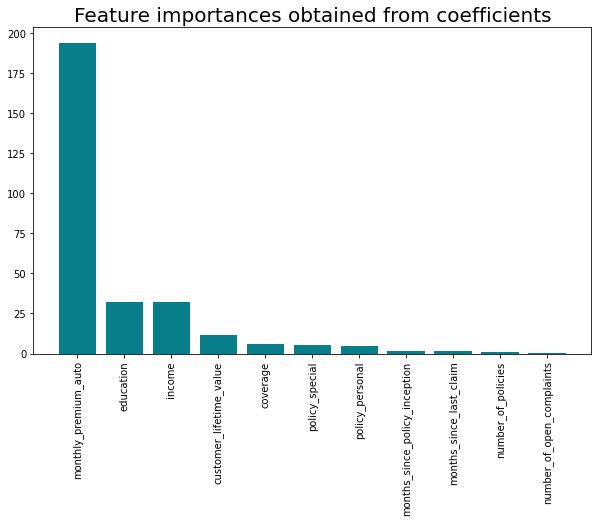

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Numerical (with outliers) + Categorial (nominal)

In [55]:
df_numerical_categorical_nominal = pd.concat((df_categorical_nominal_hotcoded, df_numerical), axis=1)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [56]:
X = df_numerical_categorical_nominal.drop('total_claim_amount', axis=1)
y = df_numerical_categorical_nominal["total_claim_amount"]

#### Train - Test - Split

In [57]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [58]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 34) (3207, 34)
Coefficients:  [ 2.49049864e+00 -1.20786721e+00  1.56541036e-01 -7.99547441e+00
 -5.37267499e-01 -6.99270917e+00  2.44496414e+00 -2.38770674e+00
  3.24871205e+01  8.64852808e+00  1.84220071e+02  8.32703264e+01
 -2.44240195e+00  2.85703819e+01  5.57603081e-01  2.83780717e+00
  7.97196205e+00  4.11562827e+00  3.31819665e+00 -7.52867354e-01
 -5.65440672e-01  1.49387148e+00  8.32270687e+00 -1.74987006e+00
 -3.23826412e+00 -4.16037683e-01 -3.03198265e+00 -5.61182157e-01
 -2.67529146e+00 -3.45404495e+00  1.73967403e+02  2.94855597e+00
 -4.07868698e-01  1.22699546e+00]


Evaluating Model Performance

In [59]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

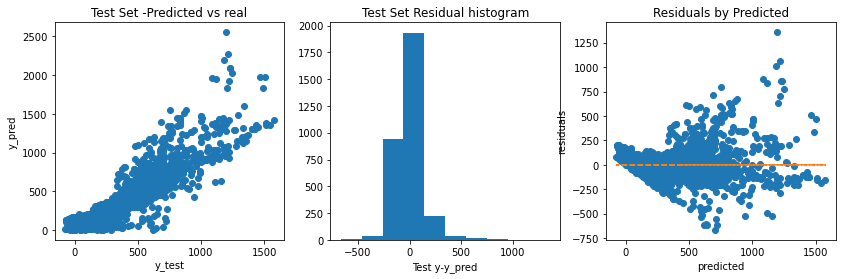

In [60]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

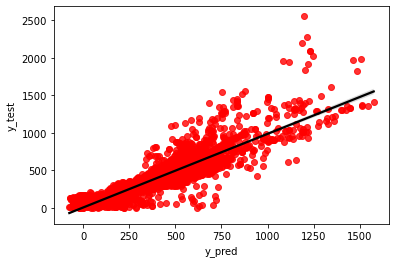

In [61]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [62]:
mse_4 = round(mse(y_test,y_pred),2)
rmse_4 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_4 = round(mae(y_test,y_pred),2)

print("MSE:", mse_4) # shows squared error (harder to interpret)
print("MAE:", mae_4) # shows real error (in $)
print("-----")

# R^2
R2_4 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_4 = round(1 - (1-R2_4)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_4,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_4,2)}.")

MSE: 19489.22
MAE: 95.77
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.76.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.76.


Getting number of parameters

In [63]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,location_code_suburban,184.220071
1,monthly_premium_auto,173.967403
2,location_code_urban,83.270326
3,employment_status_unemployed,32.487120
4,marital_status_single,28.570382
5,gender_m,8.648528
6,vehicle_class_luxury,8.322707
7,response_yes,7.995474
8,renew_offer_type_offer2,7.971962
9,employment_status_employed,6.992709


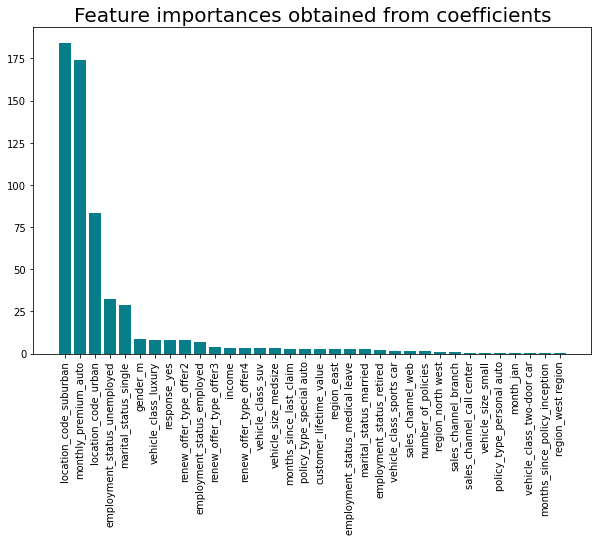

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [65]:
df_numerical

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,9,292
1,2228,92260,64,3,26,1,744
2,14947,22139,100,34,31,2,480
3,22332,49078,97,10,3,2,484
4,9025,23675,117,33,31,7,707
...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,7,1214
10685,5259,61146,65,7,68,6,273
10686,23893,39837,201,11,63,2,381
10687,11971,64195,158,0,27,6,618


### Categorial (total)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [66]:
X = df_categorical_hotcoded
y = df_numerical["total_claim_amount"]

#### Train - Test - Split

In [67]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [68]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 33) (3207, 33)
Coefficients:  [ 7.35836143e+01 -8.17350246e+00  1.40984916e+00  3.06686639e+00
  2.25958504e-01  9.11926139e-01 -6.41265665e+00 -1.67849973e+00
 -1.03485336e+01  1.31214690e+00 -3.91656097e+00  2.63972538e+01
  8.37447824e+00  1.85277723e+02  8.28126875e+01 -1.50887611e+00
  2.85815806e+01 -1.12319659e+14 -5.45579266e+13  1.12319659e+14
  5.45579266e+13  4.85078885e+00  2.13292057e+00  2.26004668e+00
 -3.16160365e-01  8.57625530e-01  1.78125709e+00  1.29560583e+02
  4.39431038e+01  7.69534229e+01 -9.48469974e-01 -1.71426704e+00
  1.88704731e-01]


Evaluating Model Performance

In [69]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

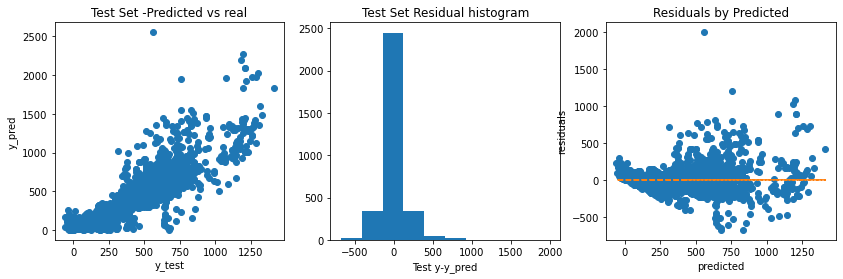

In [70]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

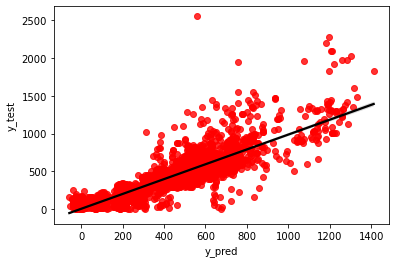

In [71]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [72]:
mse_5 = round(mse(y_test,y_pred),2)
rmse_5 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_5 = round(mae(y_test,y_pred),2)

print("MSE:", mse_5) # shows squared error (harder to interpret)
print("MAE:", mae_5) # shows real error (in $)
print("-----")

# R^2
R2_5 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_5 = round(1 - (1-R2_5)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_5,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_5,2)}.")

MSE: 23367.81
MAE: 102.53
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.72.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.72.


Getting number of parameters

In [73]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,policy_type_personal auto,1.123197e+14
1,policy_personal,1.123197e+14
2,policy_special,5.455793e+13
3,policy_type_special auto,5.455793e+13
4,location_code_suburban,1.852777e+02
5,vehicle_class_luxury,1.295606e+02
6,location_code_urban,8.281269e+01
7,vehicle_class_suv,7.695342e+01
8,coverage,7.358361e+01
9,vehicle_class_sports car,4.394310e+01


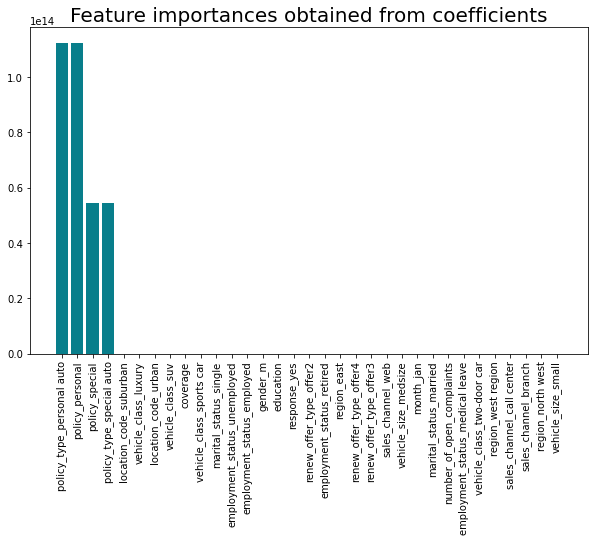

In [74]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [75]:
df_categorical_ordinal_hotcoded

,education,number_of_open_complaints,coverage,policy_personal,policy_special
0,2,0,1,0,0
1,2,0,1,1,0
2,1,0,1,1,0
3,2,0,2,0,0
4,1,0,3,1,0
...,...,...,...,...,...
10684,1,0,3,1,0
10685,2,0,1,1,0
10686,1,0,2,0,0
10687,2,4,3,1,0


### Categorial (ordinal)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [76]:
X = df_categorical_ordinal_hotcoded
y = df_numerical["total_claim_amount"]

#### Train - Test - Split

In [77]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [78]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 5) (3207, 5)
Coefficients:  [-36.83767993  -0.94058631  79.8140798    5.10287641   5.27218038]


Evaluating Model Performance

In [79]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

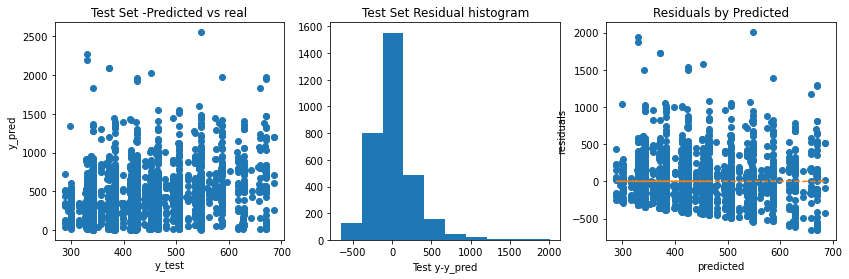

In [80]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

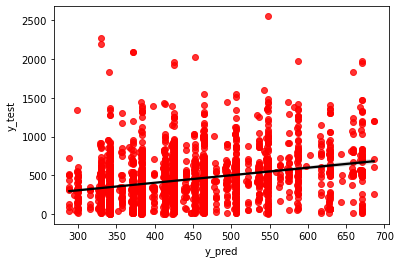

In [81]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [82]:
mse_6 = round(mse(y_test,y_pred),2)
rmse_6 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_6 = round(mae(y_test,y_pred),2)

print("MSE:", mse_6) # shows squared error (harder to interpret)
print("MAE:", mae_6) # shows real error (in $)
print("-----")

# R^2
R2_6 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_6 = round(1 - (1-R2_6)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_6,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_6,2)}.")

MSE: 75118.37
MAE: 194.31
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.09.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.09.


Getting number of parameters

In [83]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,coverage,79.814080
1,education,36.837680
2,policy_special,5.272180
3,policy_personal,5.102876
4,number_of_open_complaints,0.940586


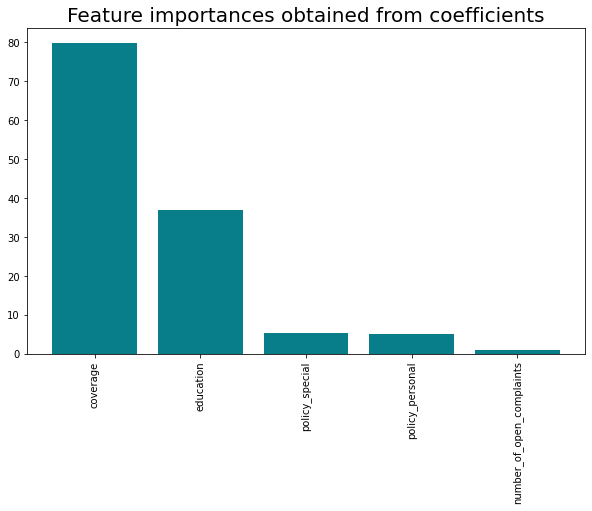

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Categorial (nominal)

#### X-y Split (`y` is the target variable, which is the `total claim amount`)

In [85]:
X = df_categorical_nominal_hotcoded
y = df_numerical["total_claim_amount"]

#### Train - Test - Split

In [86]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size,random_state=6969)

#### Standardize the data after data split

In [87]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(7482, 28) (3207, 28)
Coefficients:  [ 2.57797084e+00 -9.58383395e-01 -8.96522545e-01 -8.69627148e+00
 -1.39503112e+00 -6.73674409e+00  1.85187821e-01 -3.96718814e+00
  2.72108288e+01  7.15091102e+00  1.89682041e+02  8.06442235e+01
 -1.33747467e+00  2.86148170e+01  4.09336574e-01  2.50915926e+00
  1.05707581e+00  6.69090281e-01 -1.29264570e+00 -7.36095782e-01
  4.66736512e-01  1.20029669e+00  1.31368498e+02  4.43097347e+01
  7.52973313e+01 -2.18711866e+00 -8.82590176e-01 -9.33893613e-01]


Evaluating Model Performance

In [88]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

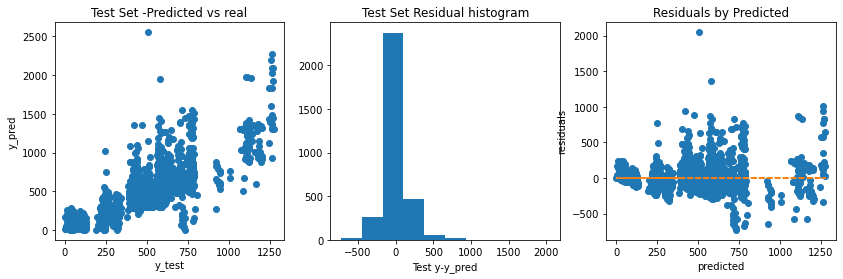

In [89]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

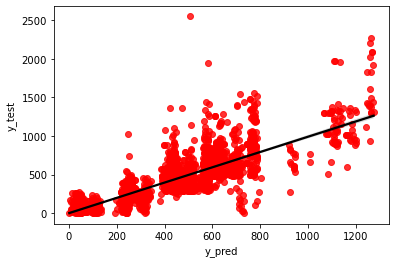

In [90]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

Error metrics

In [91]:
mse_7 = round(mse(y_test,y_pred),2)
rmse_7 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_7 = round(mae(y_test,y_pred),2)

print("MSE:", mse_7) # shows squared error (harder to interpret)
print("MAE:", mae_7) # shows real error (in $)
print("-----")

# R^2
R2_7 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_7 = round(1 - (1-R2_7)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) and categorical (total) only> is {round(R2_7,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is {round(Adj_R2_7,2)}.")

MSE: 28643.08
MAE: 115.51
-----
R^2 for <numerical (with outliers) and categorical (total) only> is 0.65.
Adjusted R^2 for <numerical (with outliers) and categorical (total) only> is 0.65.


Getting number of parameters

In [92]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
features_importances

,Attribute,Importance
0,location_code_suburban,189.682041
1,vehicle_class_luxury,131.368498
2,location_code_urban,80.644224
3,vehicle_class_suv,75.297331
4,vehicle_class_sports car,44.309735
5,marital_status_single,28.614817
6,employment_status_unemployed,27.210829
7,response_yes,8.696271
8,gender_m,7.150911
9,employment_status_employed,6.736744


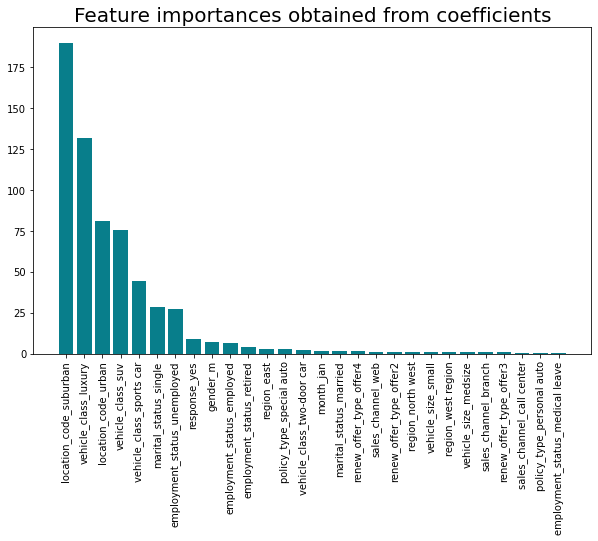

In [93]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Model Evaluation

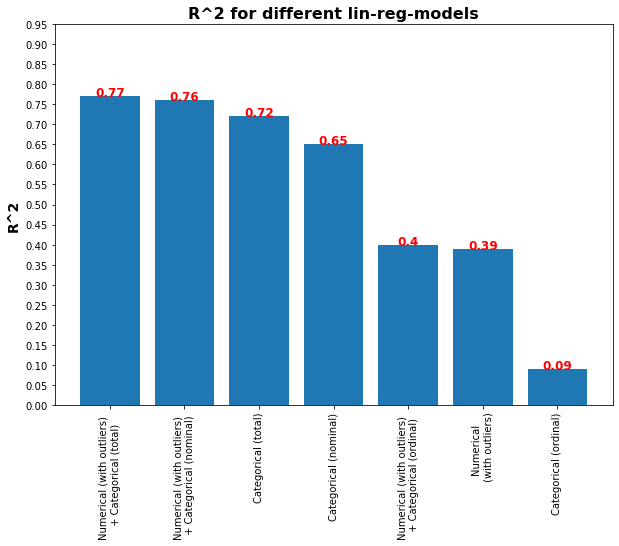

,Version,R^2,MSE,RMSE,MAE
1,Numerical (with outliers) \n + Categorical (to...,0.77,19427.29,139.38,95.60
3,Numerical (with outliers) \n + Categorical (no...,0.76,19489.22,139.60,95.77
4,Categorical (total),0.72,23367.81,152.87,102.53
6,Categorical (nominal),0.65,28643.08,169.24,115.51
2,Numerical (with outliers) \n + Categorical (or...,0.40,49836.92,223.24,153.58
0,Numerical \n (with outliers),0.39,50842.55,225.48,153.03
5,Categorical (ordinal),0.09,75118.37,274.08,194.31


In [94]:
versions = [
    "Numerical \n (with outliers)",
    "Numerical (with outliers) \n + Categorical (total)",
    "Numerical (without outliers) \n + Categorical (total)",
    "Numerical (with outliers) \n + Categorical (ordinal)",
    "Numerical (with outliers) \n + Categorical (nominal)",
    "Categorical (total)",
    "Categorical (ordinal)",
    "Categorical (nominal)"]

R2_versions = [R2_1, R2_2, R2_2a, R2_3, R2_4, R2_5, R2_6, R2_7]
adjR2_versions = [Adj_R2_1, Adj_R2_2, Adj_R2_3, Adj_R2_4, Adj_R2_5, Adj_R2_6, Adj_R2_7]
MSE_versions = [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_7]
RMSE_versions = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5, rmse_6, rmse_7]
MAE_versions = [mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7]

new = pd.DataFrame(columns=["Version", "R^2", "MSE", "RMSE", "MAE"])
new["Version"] = versions
new["R^2"] = R2_versions
new["MSE"] = MSE_versions
new["RMSE"] = RMSE_versions
new["MAE"] = MAE_versions
new.sort_values(by='R^2', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,7))
plt.title("R^2 for different lin-reg-models", size=16, weight="bold")

plt.bar(new["Version"], new["R^2"])

plt.ylabel("R^2", size=14, weight="bold")
plt.yticks(np.arange(0,int(np.ceil(max(R2_versions))),0.05))
plt.xticks(rotation="vertical")

for idx, val in enumerate(new["R^2"]):
    plt.annotate(str(val), (idx, val), ha="center", size=12, weight="bold", color="r")

plt.show()

new

In [95]:
list(df_numerical.columns)



['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_policies',
 'total_claim_amount']

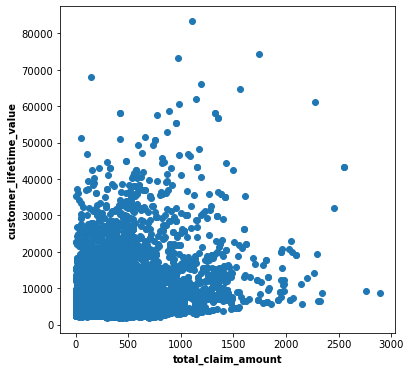

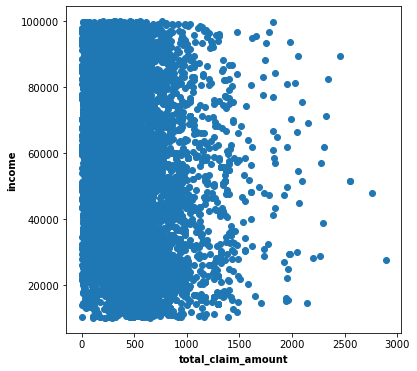

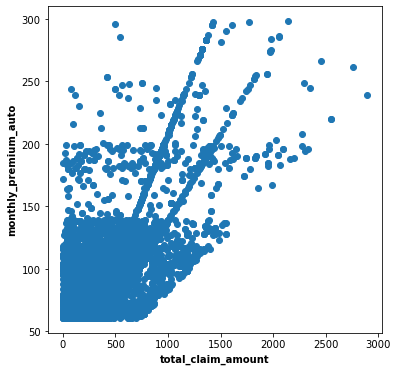

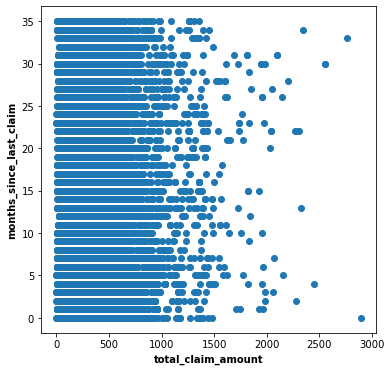

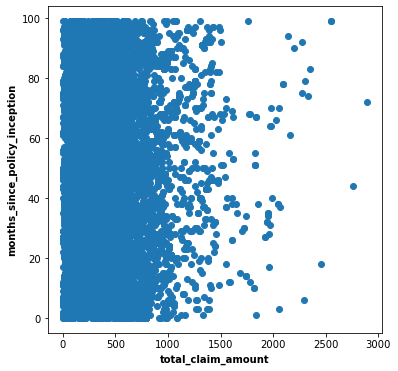

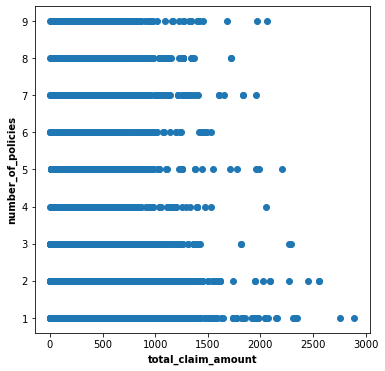

In [96]:
num_cols = ['customer_lifetime_value', 'income', 'monthly_premium_auto', 'months_since_last_claim',
             'months_since_policy_inception', 'number_of_policies']

for col in num_cols:
    fig, ax = plt.subplots(figsize=(6,6))
    plt.scatter(df_numerical["total_claim_amount"], df_numerical[col])
    plt.xlabel("total_claim_amount", weight="bold")
    plt.ylabel(col, weight="bold")
    plt.show()